In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
df = pd.read_excel("data\\train.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


<Axes: title={'center': 'Residual'}, xlabel='dt'>

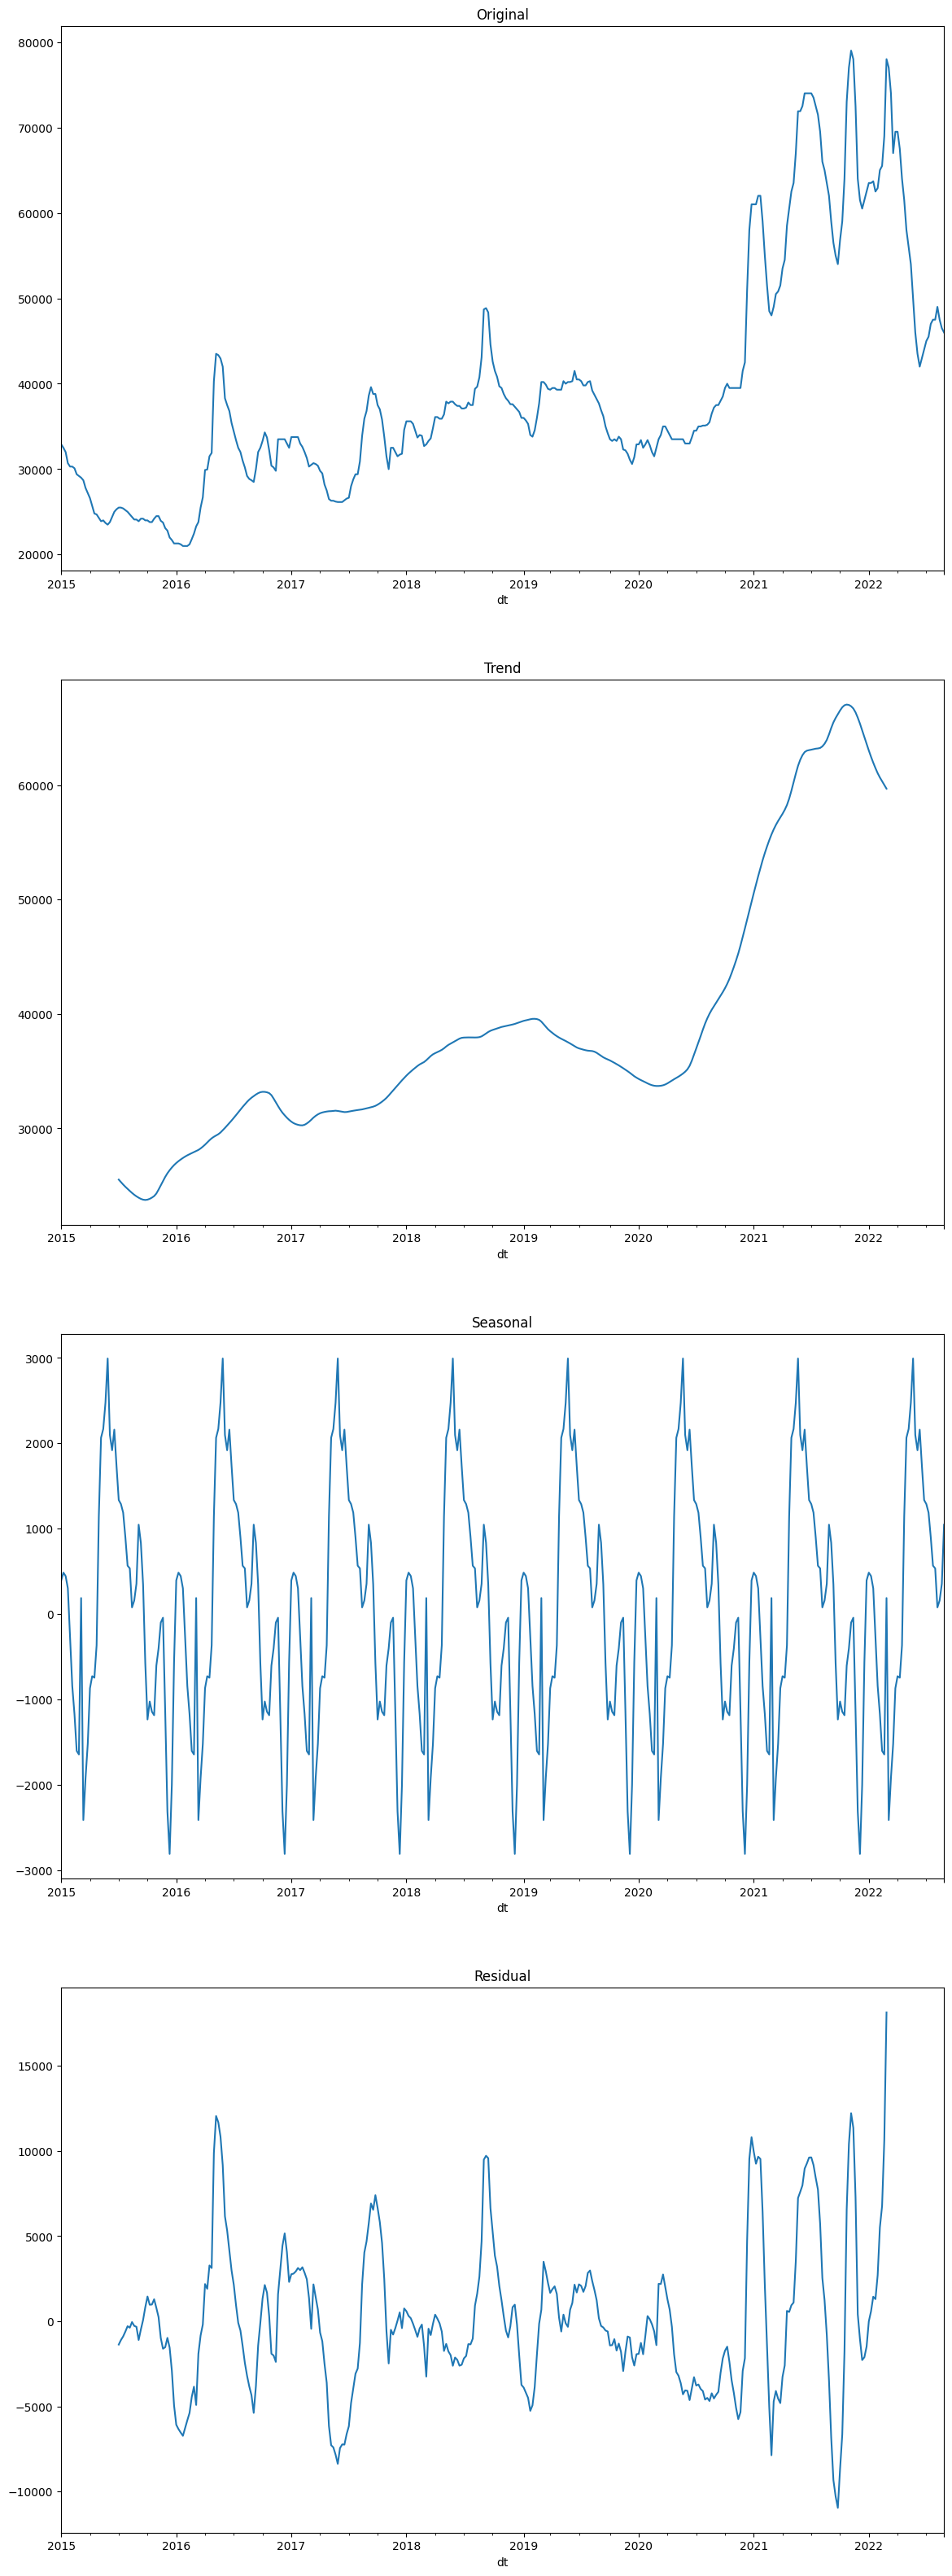

In [4]:
df.set_index("dt", inplace=True)
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df[['Цена на арматуру']])

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3])

In [5]:
chmf_df = pd.read_csv("data\\CHMF Акции.csv")
magn_df = pd.read_csv("data\\MAGN Акции.csv")
nlmk_df = pd.read_csv("data\\NLMK Акции.csv")

chmf_df.info()
magn_df.info()
nlmk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1054 entries, 0 to 1053
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1054 non-null   object
 1   Price     1054 non-null   object
 2   Open      1054 non-null   object
 3   High      1054 non-null   object
 4   Low       1054 non-null   object
 5   Vol.      1053 non-null   object
 6   Change %  1054 non-null   object
dtypes: object(7)
memory usage: 57.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053 entries, 0 to 1052
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Дата    1053 non-null   object
 1   Цена    1053 non-null   object
 2   Откр.   1053 non-null   object
 3   Макс.   1053 non-null   object
 4   Мин.    1053 non-null   object
 5   Объём   1053 non-null   object
 6   Изм. %  1053 non-null   object
dtypes: object(7)
memory usage: 57.7+ KB
<class 'pandas.core.frame.DataFrame'>
Ra

In [6]:
def clean_action_data(df):

    # Обработка объема
    def convert_volume(x):
        if isinstance(x, str):
            x = x.replace(',', '.')
            if 'K' in x:
                return float(x.replace('K', '')) * 1_000
            if 'M' in x:
                return float(x.replace('M', '')) * 1_000_000
        return float(x)
    
    
    df['Vol.'] = df['Vol.'].astype(str).apply(convert_volume)
    
    # Обработка процентов
    df['Change %'] = df['Change %'].str.replace('%', '', regex=False).str.replace(',', '.').astype(float) / 100
    
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')

In [7]:
numeric_cols = ['Price', 'Open', 'High', 'Low']

for col in numeric_cols:
        chmf_df[col] = chmf_df[col].str.replace(',', '').astype(float)

magn_df = magn_df.rename(columns={
        "Дата": "Date",
        "Цена": "Price",
        "Откр.": "Open",
        "Макс.": "High",
        "Мин.": "Low",
        "Объём": "Vol.",
        "Изм. %": "Change %"
})

magn_df["Date"] = pd.to_datetime(magn_df['Date'], format='%d.%m.%Y')

for col in numeric_cols:
        magn_df[col] = magn_df[col].str.replace(',', '.').astype(float)

for df in (chmf_df, magn_df, nlmk_df):
        clean_action_data(df)
        print(df.head())
        print(df.dtypes)
        print("\n-&-&-&-&-&-&-&-&-&-&-&-&-&-&-&-&-\n")

        Date   Price    Open    High     Low       Vol.  Change %
0 2023-03-31  1043.2  1061.0  1061.0  1042.0   571720.0   -0.0168
1 2023-03-30  1061.0  1074.6  1084.8  1058.0  1300000.0   -0.0127
2 2023-03-29  1074.6  1040.6  1078.4  1035.4  1790000.0    0.0353
3 2023-03-28  1038.0  1041.4  1044.0  1033.0   269090.0   -0.0017
4 2023-03-27  1039.8  1036.2  1042.6  1032.2   410740.0    0.0050
Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.               float64
Change %           float64
dtype: object

-&-&-&-&-&-&-&-&-&-&-&-&-&-&-&-&-

        Date  Price   Open   High    Low        Vol.  Change %
0 2023-03-31  39.69  40.21  40.24  39.52  18230000.0   -0.0138
1 2023-03-30  40.24  40.60  41.00  40.02  27140000.0   -0.0087
2 2023-03-29  40.60  39.15  40.65  38.96  48700000.0    0.0370
3 2023-03-28  39.15  39.45  39.75  38.91  17020000.0   -0.0062
4 2023-03-27  39.40  38.99  39.48  38.92  20950000

In [8]:
def aggregate_weekly(df):
    """
    Агрегирует данные по неделям (начиная с понедельника).

    Параметры:
    df (pd.DataFrame): Датафрейм с данными об акциях. Должен содержать столбец 'Date'.

    Возвращает:
    pd.DataFrame: Датафрейм, агрегированный по неделям.
    """
    df = df.copy()  # Создаем копию, чтобы не изменять оригинальный датафрейм
    
    # Приводим столбец 'Date' к формату datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
    
    # Устанавливаем дату как индекс
    df.set_index('Date', inplace=True)
    
    # Группируем по неделям (неделя заканчивается в понедельник)
    weekly_df = df.resample('W-MON').agg({
        'Price': 'mean',    # Средняя цена за неделю
        'Open': 'first',    # Цена открытия первой даты недели
        'High': 'max',      # Максимальное значение недели
        'Low': 'min',       # Минимальное значение недели
        'Vol.': 'sum',      # Суммарный объём за неделю
        'Change %': 'last'  # Последнее значение процента изменения
    })

    # Сброс индекса для возврата 'Date' в качестве столбца
    return weekly_df.reset_index()

chmf_df = aggregate_weekly(chmf_df)
magn_df = aggregate_weekly(magn_df)
nlmk_df = aggregate_weekly(nlmk_df)


In [9]:
chmf_df.to_excel("CHMF Акции_mod.xlsx", index=False)
magn_df.to_excel("MAGN Акции_mod.xlsx", index=False)
nlmk_df.to_excel("NLMK Акции_mod.xlsx", index=False)

In [24]:
lme_index_df = pd.read_excel("data\\Индекс LME.xlsx").dropna()
lme_index_df['цена'] = lme_index_df['цена'].astype(float)
lme_index_df.to_excel("Индекс LME_mod.xlsx")

lme_index_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 516 entries, 0 to 515
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   дата    516 non-null    datetime64[ns]
 1   цена    516 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.1 KB


In [38]:
temp = pd.read_excel("data\\Показатели рынка металла.xlsx")

# Устанавливаем 'dt' как индекс
temp.set_index('dt', inplace=True)

# Ресэмплинг: создаем новую временную шкалу - каждую неделю по понедельникам.
# Здесь мы используем asfreq(), чтобы установить новые даты, а затем заполним недостающие значения.
weekly_df = temp.resample('W-MON').asfreq()

# Заполним недостающие значения методом линейной интерполяции
weekly_df = weekly_df.interpolate(method='linear')

# Если нужно, можно сбросить индекс, чтобы 'dt' стал столбцом
weekly_df = weekly_df.reset_index()
weekly_df = weekly_df.dropna()
weekly_df.to_excel("temp.xlsx", index=False)
